# Perform inference with trained yolo model

## Imports

In [24]:
import os

import pyrootutils

root = pyrootutils.setup_root(
    search_from=os.path.dirname(os.getcwd()),
    indicator=[".git", "pyproject.toml"],
    pythonpath=True,
    dotenv=True,
)

if os.getenv("DATA_ROOT") is None:
    os.environ["DATA_ROOT"] = f"{root}"

In [25]:
from pathlib import Path

import cv2
import hydra
import numpy as np
import supervision as sv

In [26]:
import torch
from hydra import compose, initialize

# Setup device-agnostic code
if torch.cuda.is_available():
    DEVICE = "cuda"  # NVIDIA GPU
    print("GPU Found!!")
else:
    raise Exception("No GPU Found!!")

GPU Found!!


In [27]:
import os

os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CUDAExecutionProvider]"

## Paths setup

In [28]:
from omegaconf import DictConfig

with initialize(config_path="../configs", job_name="EDA", version_base=None):
    cfg: DictConfig = compose(config_name="inference.yaml")
    # print(OmegaConf.to_yaml(cfg))
    print(cfg.paths)

{'root_dir': '${oc.env:PROJECT_ROOT}', 'root_data_dir': '${oc.env:DATA_ROOT}', 'results_dir': '${paths.root_dir}/results', 'log_dir': '${paths.root_dir}/logs/', 'output_dir': '${hydra:runtime.output_dir}', 'work_dir': '${hydra:runtime.cwd}', 'pretrained_model_dir': '${paths.root_dir}/pretrained_models', 'embedded_model_name': 'google/siglip-base-patch16-224', 'train_bst_model': '${paths.root_dir}/results/augumented-data-yolo12l/weights/final_best.pt', 'train_lst_model': '${paths.root_dir}/results/faugumented-data-yolo12l/weights/final_last.pt', 'ip_vid_path': '${paths.root_dir}/${datasets.datasets_dir}/121364_0.mp4', 'processed_vid_path': '${paths.results_dir}/${models.model_name}_processed_121364_0.mp4'}


In [29]:
# auto reload libs
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
%matplotlib inline

In [31]:
ROOT_DIR = Path(cfg.paths.root_dir)
ROOT_DATA_DIR = Path(cfg.paths.root_data_dir)
DATA_DIR = ROOT_DATA_DIR / cfg.datasets.datasets_dir
DATASET = cfg.datasets.roboflow
DATA_DIR.mkdir(parents=True, exist_ok=True)
DATASET_DIR = DATA_DIR / cfg.datasets.dataset_name
CLASS_NAMES = cfg.datasets.names
pred_args = hydra.utils.instantiate(cfg.args, _convert_="object")

In [32]:
type(pred_args["imgsz"])

list

In [33]:
TRAIN_BST_MODEL = cfg.paths.train_bst_model
TRAIN_LST_MODEL = cfg.paths.train_lst_model
TRAIN_BST_MODEL, TRAIN_LST_MODEL

('/workspaces/football-players-tracking-yolo/results/augumented-data-yolo12l/weights/final_best.pt',
 '/workspaces/football-players-tracking-yolo/results/faugumented-data-yolo12l/weights/final_last.pt')

## Download Datasets

In [34]:
# !wget -O "121364_0.mp4" "https://drive.google.com/uc?id=1vVwjW1dE1drIdd4ZSILfbCGPD4weoNiu"

In [35]:
if len(list(DATA_DIR.iterdir())) == 0:
    from roboflow import Roboflow

    rf = Roboflow()
    project = rf.workspace(DATASET.workspace).project(DATASET.project)
    version = project.version(DATASET.version)
    dataset = version.download(model_format=DATASET.model)

## YOLO model import

In [36]:
TRAIN_BST_MODEL

'/workspaces/football-players-tracking-yolo/results/augumented-data-yolo12l/weights/final_best.pt'

In [37]:
from ultralytics import YOLO

model = YOLO(TRAIN_BST_MODEL, task="detect")

## Inference on Video

In [38]:
TEST_VIDEO = "/workspaces/football-players-tracking-yolo/data/0bfacc_0.mp4"
TEST_VIDEO2 = "/workspaces/football-players-tracking-yolo/data/121364_0.mp4"

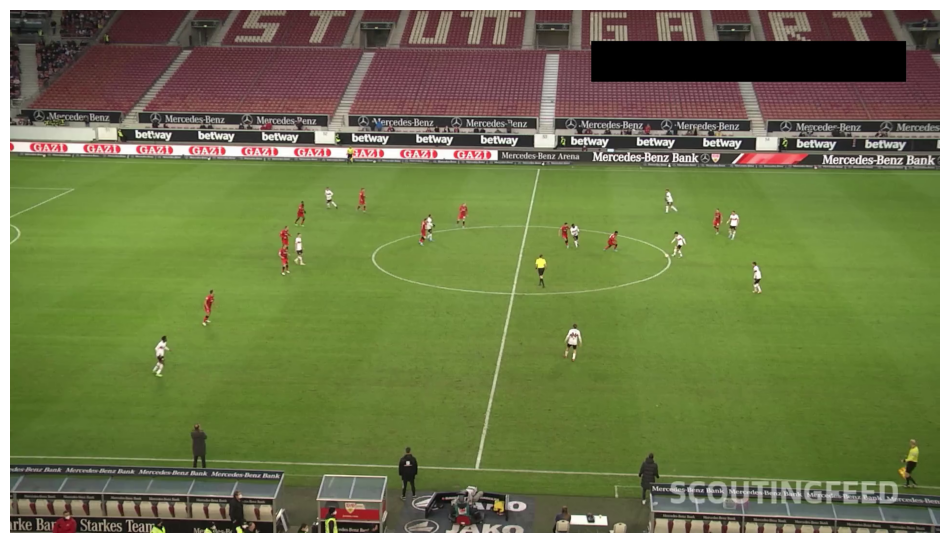

In [39]:
frame_generator = sv.get_video_frames_generator(TEST_VIDEO)
frame = next(frame_generator)
sv.plot_image(frame)

In [40]:
BALL_ID = 0
colors_list = [sv.Color.RED, sv.Color.WHITE, sv.Color.GREEN, sv.Color.BLUE]
colors = sv.ColorPalette(colors=colors_list)

# ellip_annotator = sv.EllipseAnnotator(color=colors,thickness=2)
ellip_annotator = sv.EllipseAnnotator(color=colors, thickness=2)
traingle_annot = sv.TriangleAnnotator(color=colors_list[0], base=25, height=21, outline_thickness=1)
label_annotator = sv.LabelAnnotator(color=colors, text_color=sv.Color.BLACK, text_position=sv.Position.TOP_CENTER)

In [41]:
result = model.predict(frame, imgsz=pred_args["imgsz"], conf=0.3)[0]
detections = sv.Detections.from_ultralytics(result)
detections


0: 736x1280 20 players, 3 referees, 20.8ms
Speed: 4.4ms preprocess, 20.8ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)


Detections(xyxy=array([[     293.84,      670.26,      332.81,      757.16],
       [     1142.6,      645.27,      1181.6,      726.37],
       [       1084,      501.43,      1108.4,      575.24],
       [     1531.7,      518.27,      1552.4,      587.01],
       [     1834.5,       884.2,      1876.9,      987.86],
       [     1479.3,      412.91,      1505.9,      475.85],
       [     715.28,      367.67,      736.63,      418.33],
       [     1351.2,      368.79,      1378.5,      421.16],
       [     649.47,      364.29,      676.08,      413.15],
       [     397.32,      576.55,      422.58,      652.17],
       [      587.2,       458.5,      609.34,      528.59],
       [     1156.4,      440.17,      1175.9,      492.95],
       [     1364.6,      456.64,      1396.4,       512.7],
       [     1132.2,      438.02,      1155.9,      494.84],
       [     586.79,      393.42,      611.84,      448.57],
       [       1451,      408.72,      1471.2,      465.47],
       [

In [42]:
ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

rest_detections = detections[detections.class_id != BALL_ID]
rest_detections = rest_detections.with_nms(threshold=0.5, class_agnostic=True)
rest_detections.class_id -= 1

labels = [f"{class_name} {confidence:.2f}" for class_name, confidence in zip(detections["class_name"], detections.confidence, strict=False)]
frame = frame.copy()
annot_frame = ellip_annotator.annotate(scene=frame, detections=rest_detections)

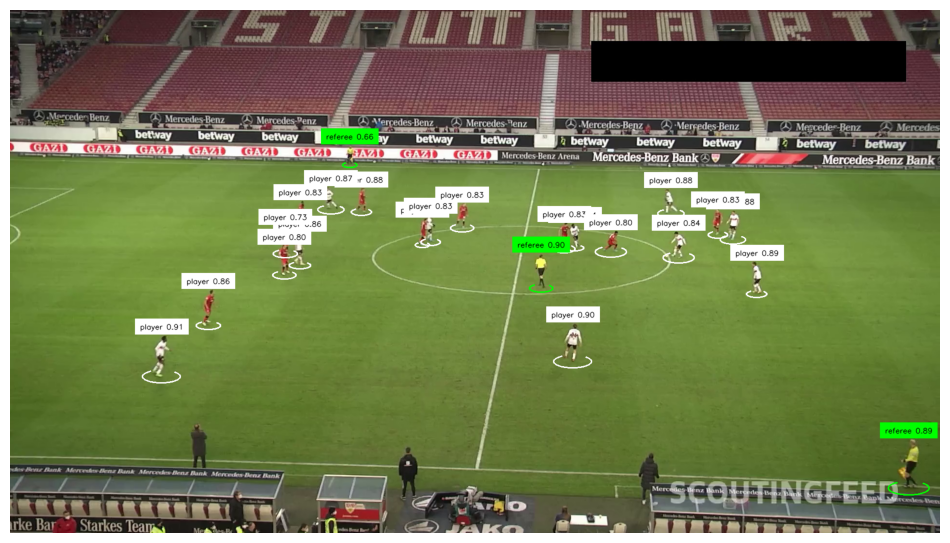

In [43]:
annot_frame = traingle_annot.annotate(scene=annot_frame, detections=ball_detections)
annotated_frame = label_annotator.annotate(scene=annot_frame, detections=rest_detections, labels=labels)
sv.plot_image(annot_frame)

In [44]:
def callback(frame: np.ndarray, _: int) -> np.ndarray:
    # https://hydra.cc/docs/advanced/instantiate_objects/overview/#parameter-conversion-strategies
    result = model.predict(frame, imgsz=pred_args["imgsz"], conf=0.3)[0]
    # result = model.predict(frame, imgsz=pred_args["imgsz"], conf=0.3)[0]
    detections = sv.Detections.from_ultralytics(result)
    ball_detections = detections[detections.class_id == BALL_ID]
    ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

    rest_detections = detections[detections.class_id != BALL_ID]
    rest_detections = rest_detections.with_nms(threshold=0.5, class_agnostic=True)
    rest_detections.class_id -= 1

    labels = [f"{class_name} {confidence:.2f}" for class_name, confidence in zip(rest_detections["class_name"], detections.confidence, strict=False)]
    annot_frame = ellip_annotator.annotate(scene=frame.copy(), detections=rest_detections)
    annot_frame = label_annotator.annotate(scene=annot_frame, detections=rest_detections, labels=labels)
    annot_frame = traingle_annot.annotate(scene=annot_frame, detections=ball_detections)
    return annot_frame


# sv.process_video(
#     source_path=TEST_VIDEO,
#     target_path="/workspaces/football-players-tracking-yolo/results/result.mp4",
#     callback=callback
# )

## Tracking players

In [46]:
def yolo_tracker_callback(frame: np.ndarray, _: int) -> np.ndarray:
    # https://hydra.cc/docs/advanced/instantiate_objects/overview/#parameter-conversion-strategies
    result = model.track(
        frame,
        show=False,
        persist=True,
    )[0]
    # result = model.predict(frame, imgsz=pred_args["imgsz"], conf=0.3)[0]
    detections = sv.Detections.from_ultralytics(result)
    ball_detections = detections[detections.class_id == BALL_ID]
    ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

    rest_detections = detections[detections.class_id != BALL_ID]
    rest_detections = rest_detections.with_nms(threshold=0.5, class_agnostic=True)
    rest_detections.class_id -= 1

    labels = [f"#{id} {confidence:.2f}" for id, confidence in zip(rest_detections.tracker_id, rest_detections.confidence, strict=False)]
    annot_frame = ellip_annotator.annotate(scene=frame.copy(), detections=rest_detections)
    annot_frame = label_annotator.annotate(scene=annot_frame, detections=rest_detections, labels=labels)
    annot_frame = traingle_annot.annotate(scene=annot_frame, detections=ball_detections)
    return annot_frame


sv.process_video(
    source_path=TEST_VIDEO, target_path="/workspaces/football-players-tracking-yolo/results/yolo_tracker_result.mp4", callback=yolo_tracker_callback
)


0: 736x1280 20 players, 3 referees, 19.0ms
Speed: 18.5ms preprocess, 19.0ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 3 referees, 20.6ms
Speed: 3.2ms preprocess, 20.6ms inference, 0.8ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 3 referees, 20.0ms
Speed: 3.5ms preprocess, 20.0ms inference, 0.8ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 3 referees, 18.5ms
Speed: 3.1ms preprocess, 18.5ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 3 referees, 19.9ms
Speed: 3.4ms preprocess, 19.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 3 referees, 20.5ms
Speed: 3.6ms preprocess, 20.5ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 3 referees, 19.6ms
Speed: 3.7ms preprocess, 19.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 7

## Detecting Players in 2 teams and annoting them in 2 colors

In [ ]:
from tqdm import tqdm

PLAYER_ID = 2
STRIDE = 20
frame_generator = sv.get_video_frames_generator(TEST_VIDEO, stride=STRIDE)

In [ ]:
players_crop = []
for frame in tqdm(frame_generator, desc="Collecting players crop"):
    result = model.predict(frame, imgsz=pred_args["imgsz"], conf=0.3)[0]
    detections = sv.Detections.from_ultralytics(result)
    # Non-maximum suppression (NMS) is a technique used in object detection to eliminate
    # redundant bounding boxes for the same object, ensuring that each object is
    # represented by a single, precise bounding box.
    player_detections = detections.with_nms(threshold=0.5, class_agnostic=True)
    player_detections = detections[detections.class_id == PLAYER_ID]
    players_crop += [sv.crop_image(frame, xyxy) for xyxy in player_detections.xyxy]

In [ ]:
sv.plot_images_grid(players_crop[:100], grid_size=(10, 10))

## SigLip to calculate embeddings for each crops

In [ ]:
import torch
from transformers import AutoProcessor, SiglipVisionModel

# bug with siglib2 - https://github.com/huggingface/transformers/issues/36399
SIGLIP_MODEL_PATH = "google/siglip-base-patch16-224"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
embedding_model = SiglipVisionModel.from_pretrained(SIGLIP_MODEL_PATH).to(DEVICE)
embedding_processor = AutoProcessor.from_pretrained(SIGLIP_MODEL_PATH)  # for feature extraction

In [ ]:
import numpy as np
from more_itertools import chunked

BATCH_SIZE = 32
# AutoProcessor expects pillow images
crops = [sv.cv2_to_pillow(crop) for crop in players_crop]
batches = chunked(crops, BATCH_SIZE)
data_list = []

# reduce memory consumption and speed up inference
with torch.no_grad():
    for batch in tqdm(batches, desc="Extracting embeddings"):
        _batch = embedding_processor(images=batch, return_tensors="pt").to(DEVICE)
        outputs = embedding_model(**_batch)
        embeddings = torch.mean(outputs.last_hidden_state, dim=1)
        data_list.append(embeddings.cpu().numpy())

In [ ]:
data = np.concatenate(data_list, axis=0)
data.shape

Using UMAP, we project our embeddings from (N, 768) to (N, 3) and then perform a two-cluster division using KMeans.

In [ ]:
import umap
from sklearn.cluster import KMeans

reducer = umap.UMAP(n_components=3)
projections = reducer.fit_transform(data)
kmeans = KMeans(n_clusters=2, random_state=0)
team_labels = kmeans.fit_predict(projections)
team_labels

In [ ]:
# Plot with Plotly Express
import plotly.express as px

fig = px.scatter_3d(
    x=projections[:, 0],
    y=projections[:, 1],
    z=projections[:, 2],
    color=team_labels.astype(str),  # Color by cluster
    title="Player Embedding Clusters",
    labels={"color": "Team"},
    hover_name=[f"Player {i}" for i in range(len(team_labels))],  # Optional hover text
)
fig.update_traces(marker_size=10)
fig.show()

## Add detect and track players separately

In [ ]:
cfg.datasets.names

In [ ]:
BALL_ID = 0
colors_list = [sv.Color.WHITE, sv.Color.GREEN, sv.Color.YELLOW]
colors = sv.ColorPalette(colors=colors_list)

ellip_annotator = sv.EllipseAnnotator(color=colors, thickness=2)
traingle_annot = sv.TriangleAnnotator(color=sv.Color.RED, base=25, height=21, outline_thickness=1)
label_annotator = sv.LabelAnnotator(color=colors, text_color=sv.Color.BLACK, text_position=sv.Position.TOP_CENTER)
model = YOLO(TRAIN_BST_MODEL)

In [ ]:
frame_generator = sv.get_video_frames_generator(TEST_VIDEO)
frame = next(frame_generator)

result = model(frame)[0]
detections = sv.Detections.from_ultralytics(result)
tracker = sv.ByteTrack()
tracker.reset()

In [ ]:
ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

rest_detections = detections[detections.class_id != BALL_ID]
rest_detections = rest_detections.with_nms(threshold=0.5, class_agnostic=True)
rest_detections.class_id -= 1

rest_detections = tracker.update_with_detections(detections=rest_detections)

labels = [f"#{int(id)}" for id in rest_detections.tracker_id]

frame = frame.copy()
annot_frame = ellip_annotator.annotate(scene=frame, detections=rest_detections)
annot_frame = traingle_annot.annotate(scene=annot_frame, detections=ball_detections)
annotated_frame = label_annotator.annotate(scene=annot_frame, detections=rest_detections, labels=labels)
sv.plot_image(annotated_frame)

In [ ]:
def tracker_callback(frame: np.ndarray, _: int) -> np.ndarray:
    # https://hydra.cc/docs/advanced/instantiate_objects/overview/#parameter-conversion-strategies
    result = model.predict(frame, **pred_args)[0]
    detections = sv.Detections.from_ultralytics(result)
    # --- ball detection ---
    ball_detections = detections[detections.class_id == BALL_ID]
    ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

    # --- Players detection ---
    rest_detections = detections[detections.class_id != BALL_ID]
    rest_detections = rest_detections.with_nms(threshold=0.5, class_agnostic=True)
    rest_detections.class_id -= 1

    rest_detections = tracker.update_with_detections(detections=rest_detections)

    labels = [f"#{int(id)}" for id in rest_detections.tracker_id]

    frame = frame.copy()
    annot_frame = ellip_annotator.annotate(scene=frame, detections=rest_detections)
    annot_frame = traingle_annot.annotate(scene=annot_frame, detections=ball_detections)
    annot_frame = label_annotator.annotate(scene=annot_frame, detections=rest_detections, labels=labels)
    return annot_frame


tracker = sv.ByteTrack()
tracker.reset()

# sv.process_video(
#     source_path=TEST_VIDEO,
#     target_path="/workspaces/football-players-tracking-yolo/results/result_tracker.mp4",
#     callback=tracker_callback,
# )

## Tracking players from both team separately

In [ ]:
# ['goalkeeper', 'team_player1','team_player2', 'referee']
colors_list = [
    sv.Color.YELLOW,  # Index 0 (Goalkeeper)
    sv.Color.RED,  # Index 1 (Team 1)
    sv.Color.GREEN,  # Index 2 (Team 2)
    sv.Color.WHITE,  # Index 3 (Referee)
]
colors = sv.ColorPalette(colors=colors_list)

ellip_annotator = sv.EllipseAnnotator(color=colors, thickness=2)
traingle_annot = sv.TriangleAnnotator(color=sv.Color.RED, base=25, height=21, outline_thickness=1)
label_annotator = sv.LabelAnnotator(color=colors, text_color=sv.Color.BLACK, text_position=sv.Position.TOP_CENTER)

# --- Configuration ---
# Final Class IDs and corresponding labels/colors
# We will map dynamically detected teams to IDs 2 and 3
FINAL_CLASS_ID_GOALKEEPER = 0
FINAL_CLASS_ID_TEAM_1 = 1
FINAL_CLASS_ID_TEAM_2 = 2
FINAL_CLASS_ID_REFEREE = 3

# Original Model Output Class IDs
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

TEST_VIDEO_2 = "/workspaces/football-players-tracking-yolo/data/121364_0.mp4"

SIGLIP_MODEL_PATH = "google/siglip-base-patch16-224"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
embedding_model = SiglipVisionModel.from_pretrained(SIGLIP_MODEL_PATH).to(DEVICE)
embedding_processor = AutoProcessor.from_pretrained(SIGLIP_MODEL_PATH)  # for feature extraction

_umap = umap.UMAP(n_components=3, random_state=cfg.seed)
_kmeans = KMeans(n_clusters=2, n_init="auto", random_state=cfg.seed)

In [ ]:
frame_generator = sv.get_video_frames_generator(TEST_VIDEO_2, stride=30)

crops = []
for frame in tqdm(frame_generator, desc="collecting crops"):
    result = model.predict(frame, **pred_args)[0]
    detections = sv.Detections.from_ultralytics(result)
    players_detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

batches = chunked(crops, BATCH_SIZE)
data_list = []

# reduce memory consumption and speed up inference
with torch.no_grad():
    for batch in tqdm(batches, desc="Extracting embeddings"):
        _batch = embedding_processor(images=batch, return_tensors="pt").to(DEVICE)
        outputs = embedding_model(**_batch)
        embeddings = torch.mean(outputs.last_hidden_state, dim=1)
        data_list.append(embeddings.cpu().numpy())
data = np.concatenate(data_list)
_kmeans.fit(_umap.fit_transform(data))

In [ ]:
# --- Callback Function ---
def separate_teams_callback(frame: np.ndarray, frame_index: int) -> np.ndarray:
    _frame = frame.copy()

    # --- Object Detection ---
    result = model.predict(frame, **pred_args)[0]
    detections = sv.Detections.from_ultralytics(result)

    # --- Ball Detection ---
    ball_detections = detections[detections.class_id == BALL_ID]
    ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

    # --- Non-Ball Detections & Tracking ---
    non_ball_detections = detections[detections.class_id != BALL_ID]
    non_ball_detections = non_ball_detections.with_nms(
        threshold=0.5,
        class_agnostic=False,  # Usually better to do NMS per class
    )
    non_ball_detections = _tracker.update_with_detections(detections=non_ball_detections)

    # --- Separate Detections by Original Class ---
    goalkeepers_detections = non_ball_detections[non_ball_detections.class_id == GOALKEEPER_ID]
    players_detections = non_ball_detections[non_ball_detections.class_id == PLAYER_ID]
    referees_detections = non_ball_detections[non_ball_detections.class_id == REFEREE_ID]

    # --- Team Separation for Players ---

    players_crop = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
    crops = [sv.cv2_to_pillow(crop) for crop in players_crop]

    batches = chunked(crops, BATCH_SIZE)
    data_list = []

    with torch.no_grad():
        for batch in batches:
            _batch = embedding_processor(images=batch, return_tensors="pt").to(DEVICE)
            outputs = embedding_model(**_batch)
            embeddings = torch.mean(outputs.last_hidden_state, dim=1)
            data_list.append(embeddings.cpu().numpy())

    if data_list:
        projections = _umap.transform(np.concatenate(data_list))

        # Cluster the projections
        cluster_ids = _kmeans.predict(projections)  # IDs are 0 or 1

        # Assign FINAL Class IDs (2 and 3) based on (potentially corrected) cluster IDs
        players_detections.class_id = cluster_ids + FINAL_CLASS_ID_TEAM_1  # Map 0->1, 1->2

    # --- Assign Final Class IDs ---
    # Goalkeepers get final ID 1
    goalkeepers_detections.class_id = np.full(len(goalkeepers_detections), FINAL_CLASS_ID_GOALKEEPER)
    # Referees get final ID 4
    referees_detections.class_id = np.full(len(referees_detections), FINAL_CLASS_ID_REFEREE)

    # --- Merge all detections for annotation --
    all_detections = sv.Detections.merge([goalkeepers_detections, players_detections, referees_detections])
    # Ensure class_id is integer type for palette indexing
    all_detections.class_id = all_detections.class_id.astype(int)

    # --- Create Labels (Using Tracker ID) ---
    labels = [f"#{tid}" for tid in all_detections.tracker_id]

    # --- Annotation ---
    # Annotate non-ball detections (Goalkeepers, Players, Referees) with ellipses
    annot_frame = ellip_annotator.annotate(scene=_frame, detections=all_detections)

    # Annotate the ball separately
    annot_frame = traingle_annot.annotate(scene=annot_frame, detections=ball_detections)

    # Add labels to non-ball detections
    annot_frame = label_annotator.annotate(scene=annot_frame, detections=all_detections, labels=labels)
    return annot_frame


_tracker = sv.ByteTrack()
_tracker.reset()

output_file = Path(cfg.paths.results_dir) / "result_seperate_teams.mp4"
output_file.unlink(missing_ok=True)  # Remove existing file if it exists

sv.process_video(
    source_path=TEST_VIDEO_2,
    target_path=str(output_file),
    callback=separate_teams_callback,
)

In [ ]:
# !pip install git+https://github.com/roboflow/sports.git

In [ ]:
from sports.common.team import TeamClassifier

PLAYER_ID = 2
STRIDE = 30

frame_generator = sv.get_video_frames_generator(source_path=TEST_VIDEO_2, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc="collecting crops"):
    result = model.predict(frame, **pred_args)[0]
    detections = sv.Detections.from_ultralytics(result)
    players_detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

team_classifier = TeamClassifier(device="cuda")
team_classifier.fit(crops)

In [ ]:
# --- Callback Function ---
def separate_teams_callback(frame: np.ndarray, frame_index: int) -> np.ndarray:
    global previous_centroids  # Use global state for centroids across calls
    _frame = frame.copy()

    # --- Object Detection ---
    result = model.predict(frame, **pred_args)[0]
    detections = sv.Detections.from_ultralytics(result)

    # --- Ball Detection ---
    ball_detections = detections[detections.class_id == BALL_ID]
    # Optional: Pad ball boxes if needed
    # ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

    # --- Non-Ball Detections & Tracking ---
    non_ball_detections = detections[detections.class_id != BALL_ID]
    non_ball_detections = non_ball_detections.with_nms(
        threshold=0.5,
        class_agnostic=False,  # Usually better to do NMS per class
    )
    # Add tracker IDs
    non_ball_detections = tracker.update_with_detections(detections=non_ball_detections)

    # --- Separate Detections by Original Class ---
    goalkeepers_detections = non_ball_detections[non_ball_detections.class_id == GOALKEEPER_ID]
    players_detections = non_ball_detections[non_ball_detections.class_id == PLAYER_ID]
    referees_detections = non_ball_detections[non_ball_detections.class_id == REFEREE_ID]

    players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
    players_detections.class_id = team_classifier.predict(players_crops)

    # --- Assign Final Class IDs ---
    # Goalkeepers get final ID 1
    goalkeepers_detections.class_id = np.full(len(goalkeepers_detections), FINAL_CLASS_ID_GOALKEEPER)
    # Referees get final ID 4
    referees_detections.class_id = np.full(len(referees_detections), FINAL_CLASS_ID_REFEREE)

    # --- Merge all detections for annotation --
    all_detections = sv.Detections.merge([goalkeepers_detections, players_detections, referees_detections])
    # Ensure class_id is integer type for palette indexing
    all_detections.class_id = all_detections.class_id.astype(int)

    # --- Create Labels (Using Tracker ID) ---
    labels = [f"#{tid}" for tid in all_detections.tracker_id]

    # --- Annotation ---
    annot_frame = _frame  # Start with a copy of the current frame

    # Annotate non-ball detections (Goalkeepers, Players, Referees) with ellipses
    annot_frame = ellip_annotator.annotate(scene=annot_frame, detections=all_detections)

    # Annotate the ball separately
    annot_frame = traingle_annot.annotate(scene=annot_frame, detections=ball_detections)

    # Add labels to non-ball detections
    annot_frame = label_annotator.annotate(scene=annot_frame, detections=all_detections, labels=labels)
    return annot_frame


tracker = sv.ByteTrack()
tracker.reset()

output_file = Path(cfg.paths.results_dir) / "result_seperate_teams.mp4"
output_file.unlink(missing_ok=True)  # Remove existing file if it exists

sv.process_video(
    source_path=TEST_VIDEO_2,
    target_path=str(output_file),
    callback=separate_teams_callback,
)